## Preprocessing and EDA for Retailrocket Dataset

In [1]:
import pandas as pd

# Load the events dataset
event = pd.read_csv('C:/Users/nafla/Downloads/article/dataset/events.csv', dtype={'visitorid': int, 'event': str, 'itemid': int})
event['timestamp'] = pd.to_datetime(event['timestamp'], unit='ms')  # Convert from Unix time in milliseconds


In [2]:
event.head()

,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12.117,257597,view,355908,NaN
1,2015-06-02 05:50:14.164,992329,view,248676,NaN
2,2015-06-02 05:13:19.827,111016,view,318965,NaN
3,2015-06-02 05:12:35.914,483717,view,253185,NaN
4,2015-06-02 05:02:17.106,951259,view,367447,NaN


In [3]:
import pandas as pd

# Load item properties
item_properties_part1 = pd.read_csv('C:/Users/nafla/Downloads/article/dataset/item_properties_part1.csv')
item_properties_part2 = pd.read_csv('C:/Users/nafla/Downloads/article/dataset/item_properties_part2.csv')

# Combine item properties
item_properties = pd.concat([item_properties_part1, item_properties_part2])
item_properties.sort_values(by=['itemid', 'timestamp'], inplace=True)

# Convert timestamps in item_properties for proper merging
item_properties['timestamp'] = pd.to_datetime(item_properties['timestamp'], unit='ms')

# Filter for 'categoryid' properties
item_properties_category = item_properties[item_properties['property'] == 'categoryid']



In [4]:
# Calculating the number of unique values in each column
unique_counts = item_properties.nunique()

# Calculating the number of missing values in each column
missing_counts = item_properties.isnull().sum()

# Combining both information into a single DataFrame for better visualization
summary_df = pd.DataFrame({
    'Unique Counts': unique_counts,
    'Missing Counts': missing_counts
})

# Display the summary DataFrame
print(summary_df)

           Unique Counts  Missing Counts
timestamp             18               0
itemid            417053               0
property            1104               0
value            1966868               0


In [5]:
import numpy as np
event['itemid']= event['itemid'].astype(np.int64)

In [6]:

# Load events data and prepare timestamps
event['timestamp'] = pd.to_datetime(event['timestamp'], unit='ms')

# Merge events with item properties
data = pd.merge_asof(event.sort_values('timestamp'), item_properties_category.sort_values('timestamp'),
                     on='timestamp', by='itemid', direction='backward')
# Use groupby and bfill to fill NaN values backward within each 'itemid' group
data['value'] = data.groupby('itemid')['value'].bfill()
data['value'] = data['value'].fillna('no_category')


In [7]:
data.head()

,timestamp,visitorid,event,itemid,transactionid,property,value
0,2015-05-03 03:00:04.384,693516,addtocart,297662,NaN,NaN,1130
1,2015-05-03 03:00:11.289,829044,view,60987,NaN,NaN,463
2,2015-05-03 03:00:13.048,652699,view,252860,NaN,NaN,no_category
3,2015-05-03 03:00:24.154,1125936,view,33661,NaN,NaN,1628
4,2015-05-03 03:00:26.228,693516,view,297662,NaN,NaN,1130


In [8]:
# Rename the 'value' column to 'category'
data = data.rename(columns={'value': 'category'})

# Drop the 'property' column
data = data.drop(columns=['property'])

# Check the updated DataFrame
print(data.head())

                timestamp  visitorid      event  itemid  transactionid  \
0 2015-05-03 03:00:04.384     693516  addtocart  297662            NaN   
1 2015-05-03 03:00:11.289     829044       view   60987            NaN   
2 2015-05-03 03:00:13.048     652699       view  252860            NaN   
3 2015-05-03 03:00:24.154    1125936       view   33661            NaN   
4 2015-05-03 03:00:26.228     693516       view  297662            NaN   

      category  
0         1130  
1          463  
2  no_category  
3         1628  
4         1130  


In [9]:
# creating sessions based on timestamp
# Sort the data by visitorid and timestamp
data.sort_values(by=['visitorid', 'timestamp'], inplace=True)

# Define a session threshold (e.g., 30 minutes)
session_threshold = pd.Timedelta(minutes=30)

# Calculate time differences between user activities
data['time_diff'] = data.groupby('visitorid')['timestamp'].diff()

# Identify where new sessions should start
data['new_session'] = (data['time_diff'] > session_threshold).astype(int)

# Cumulatively sum the new_session flags to create unique session IDs per user
data['session_id'] = data.groupby('visitorid')['new_session'].cumsum()


In [10]:
# Determine the start and end of each session
data['session_start'] = data.groupby(['visitorid', 'session_id'])['timestamp'].transform('min')
data['session_end'] = data.groupby(['visitorid', 'session_id'])['timestamp'].transform('max')
data['session_duration'] = (data['session_end'] - data['session_start']).dt.total_seconds()

# Format the session duration with leading zeros, max length of 5
data['session_duration_formatted'] = data['session_duration'].apply(lambda x: f"{int(x):05d}s")

In [11]:
# Create a global session ID with placeholders and formatted duration
data['global_session_id'] = data.apply(
    lambda x: f"{x['visitorid']}:START:{x['session_start'].strftime('%Y%m%d%H%M%S')}:DUR:{x['session_duration_formatted']}",
    axis=1
)

In [12]:
data.head()

,timestamp,visitorid,event,itemid,transactionid,category,time_diff,new_session,session_id,session_start,session_end,session_duration,session_duration_formatted,global_session_id
2655436,2015-09-11 20:49:49.439,0,view,285930,NaN,1188,NaT,0,0,2015-09-11 20:49:49.439,2015-09-11 20:55:17.175,327.736,00327s,0:START:20150911204949:DUR:00327s
2655495,2015-09-11 20:52:39.591,0,view,357564,NaN,256,0 days 00:02:50.152000,0,0,2015-09-11 20:49:49.439,2015-09-11 20:55:17.175,327.736,00327s,0:START:20150911204949:DUR:00327s
2655555,2015-09-11 20:55:17.175,0,view,67045,NaN,333,0 days 00:02:37.584000,0,0,2015-09-11 20:49:49.439,2015-09-11 20:55:17.175,327.736,00327s,0:START:20150911204949:DUR:00327s
2126598,2015-08-13 17:46:06.444,1,view,72028,NaN,1192,NaT,0,0,2015-08-13 17:46:06.444,2015-08-13 17:46:06.444,0.000,00000s,1:START:20150813174606:DUR:00000s
2024720,2015-08-07 17:51:44.567,2,view,325215,NaN,299,NaT,0,0,2015-08-07 17:51:44.567,2015-08-07 18:20:57.845,1753.278,01753s,2:START:20150807175144:DUR:01753s


In [13]:


# Calculate the time since the start of the session
data['time_since_session_start'] = (data['timestamp'] - data['session_start']).dt.total_seconds()


In [14]:
# drop columns used for intermediate calculations
data.drop(columns=['new_session', 'session_start', 'session_end', 'session_duration_formatted', 'transactionid', 'session_id'], inplace=True)
data.head()

,timestamp,visitorid,event,itemid,category,time_diff,session_duration,global_session_id,time_since_session_start
2655436,2015-09-11 20:49:49.439,0,view,285930,1188,NaT,327.736,0:START:20150911204949:DUR:00327s,0.000
2655495,2015-09-11 20:52:39.591,0,view,357564,256,0 days 00:02:50.152000,327.736,0:START:20150911204949:DUR:00327s,170.152
2655555,2015-09-11 20:55:17.175,0,view,67045,333,0 days 00:02:37.584000,327.736,0:START:20150911204949:DUR:00327s,327.736
2126598,2015-08-13 17:46:06.444,1,view,72028,1192,NaT,0.000,1:START:20150813174606:DUR:00000s,0.000
2024720,2015-08-07 17:51:44.567,2,view,325215,299,NaT,1753.278,2:START:20150807175144:DUR:01753s,0.000


In [15]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
le = LabelEncoder()

# Fit the encoder to the 'event' column
data['interaction_type_id'] = le.fit_transform(data['event']) + 1  # Add 1 to start encoding from 1


In [16]:
# Display the unique event types and their assigned IDs
event_types = pd.DataFrame({
    'Event': le.classes_,
    'Encoded_ID': le.transform(le.classes_) + 1
})
print(event_types)


         Event  Encoded_ID
0    addtocart           1
1  transaction           2
2         view           3


In [17]:
# Calculating the number of unique values in each column
unique_counts = data.nunique()

# Calculating the number of missing values in each column
missing_counts = data.isnull().sum()

# Combining both information into a single DataFrame for better visualization
summary_df = pd.DataFrame({
    'Unique Counts': unique_counts,
    'Missing Counts': missing_counts
})

# Display the summary DataFrame
print(summary_df)

                          Unique Counts  Missing Counts
timestamp                       2750455               0
visitorid                       1407580               0
event                                 3               0
itemid                           235061               0
category                           1140               0
time_diff                        731679         1407580
session_duration                 285761               0
global_session_id               1761675               0
time_since_session_start         651148               0
interaction_type_id                   3               0


In [18]:
# Calculate item popularity (total interactions per item across all users)
data['item_popularity'] = data.groupby('itemid')['itemid'].transform('count')

# Calculate item preference (total interactions per item per user)
data['item_preference'] = data.groupby(['visitorid', 'itemid'])['itemid'].transform('count')





In [19]:
data['time_since_last_interaction'] = data.groupby('visitorid')['timestamp'].diff().dt.total_seconds()
data['time_since_last_interaction'] = data['time_since_last_interaction'].fillna(0)

In [20]:
data.head()

,timestamp,visitorid,event,itemid,category,time_diff,session_duration,global_session_id,time_since_session_start,interaction_type_id,item_popularity,item_preference,time_since_last_interaction
2655436,2015-09-11 20:49:49.439,0,view,285930,1188,NaT,327.736,0:START:20150911204949:DUR:00327s,0.000,3,95,1,0.000
2655495,2015-09-11 20:52:39.591,0,view,357564,256,0 days 00:02:50.152000,327.736,0:START:20150911204949:DUR:00327s,170.152,3,271,1,170.152
2655555,2015-09-11 20:55:17.175,0,view,67045,333,0 days 00:02:37.584000,327.736,0:START:20150911204949:DUR:00327s,327.736,3,205,1,157.584
2126598,2015-08-13 17:46:06.444,1,view,72028,1192,NaT,0.000,1:START:20150813174606:DUR:00000s,0.000,3,52,1,0.000
2024720,2015-08-07 17:51:44.567,2,view,325215,299,NaT,1753.278,2:START:20150807175144:DUR:01753s,0.000,3,114,3,0.000


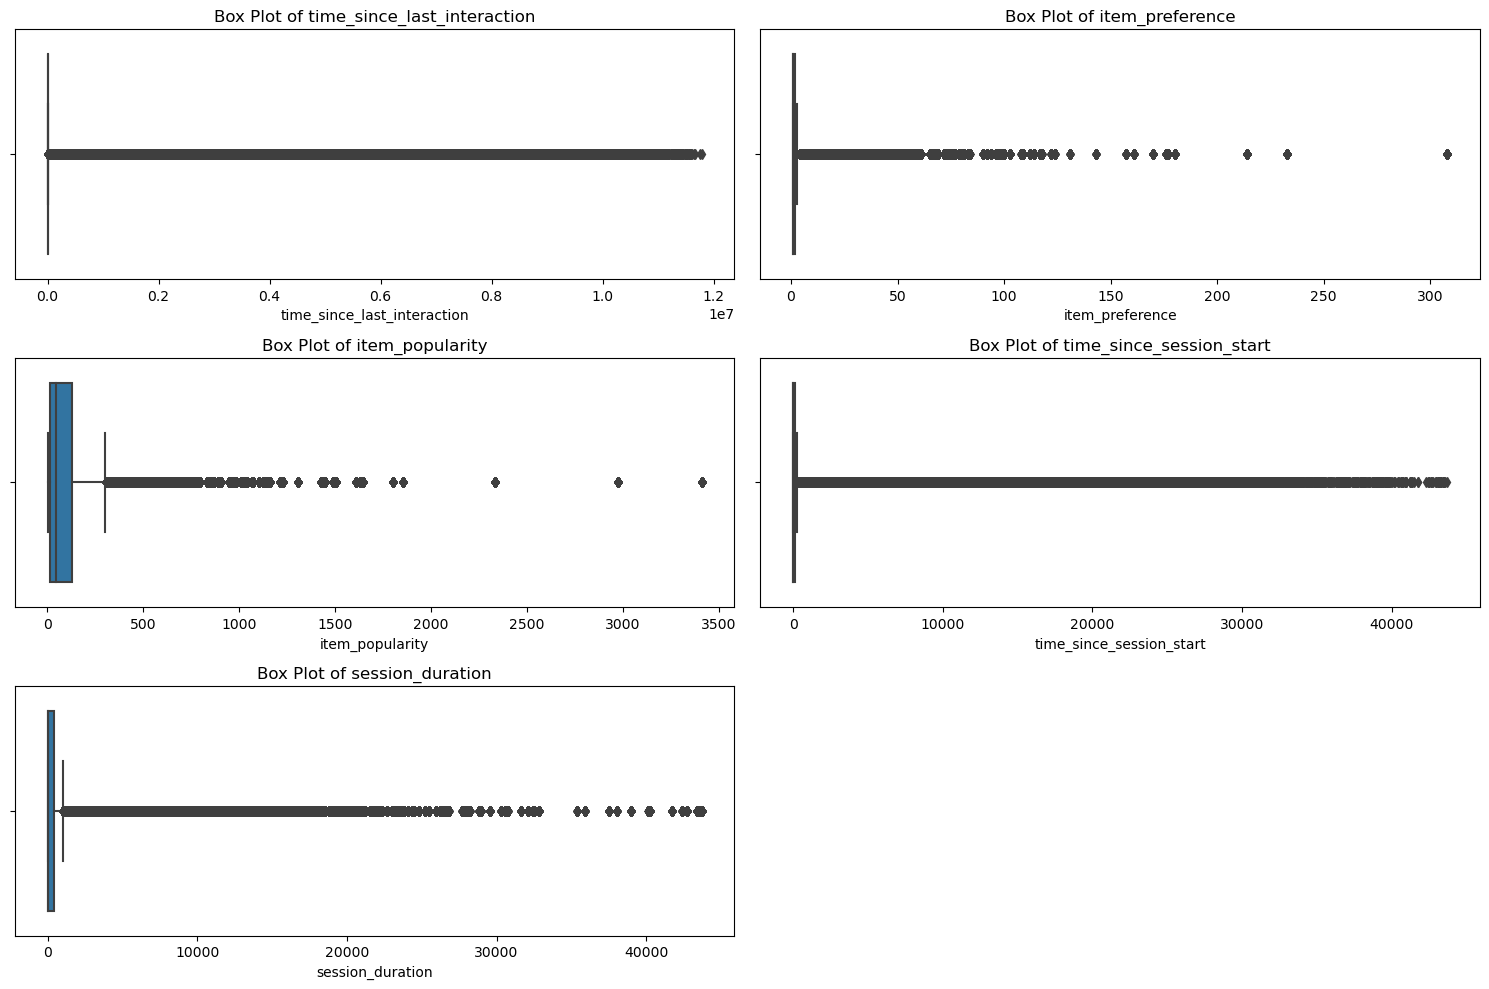

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of features to plot
features = ['time_since_last_interaction', 'item_preference', 'item_popularity', 'time_since_session_start', 'session_duration']

# Create a figure and a set of subplots
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)  # Adjust grid parameters based on the number of features
    sns.boxplot(x=data[feature].dropna())  # Drop NA values for cleaner plotting
    plt.title(f'Box Plot of {feature}')

plt.tight_layout()
plt.show()


In [22]:
import numpy as np

# log transform feature that are highly skewed to left
features_to_transform = ['time_since_last_interaction', 'item_preference', 'item_popularity', 'time_since_session_start', 'session_duration']

# Apply log1p to each specified feature
for feature in features_to_transform:
    data[feature + '_log'] = np.log1p(data[feature])

# Check the transformed data
print(data[['time_since_last_interaction_log', 'item_preference_log', 'item_popularity_log', 'time_since_session_start_log', 'session_duration_log']].head())


         time_since_last_interaction_log  item_preference_log  \
2655436                         0.000000             0.693147   
2655495                         5.142552             0.693147   
2655555                         5.066284             0.693147   
2126598                         0.000000             0.693147   
2024720                         0.000000             1.386294   

         item_popularity_log  time_since_session_start_log  \
2655436             4.564348                      0.000000   
2655495             5.605802                      5.142552   
2655555             5.327876                      5.795255   
2126598             3.970292                      0.000000   
2024720             4.744932                      0.000000   

         session_duration_log  
2655436              5.795255  
2655495              5.795255  
2655555              5.795255  
2126598              0.000000  
2024720              7.469813  


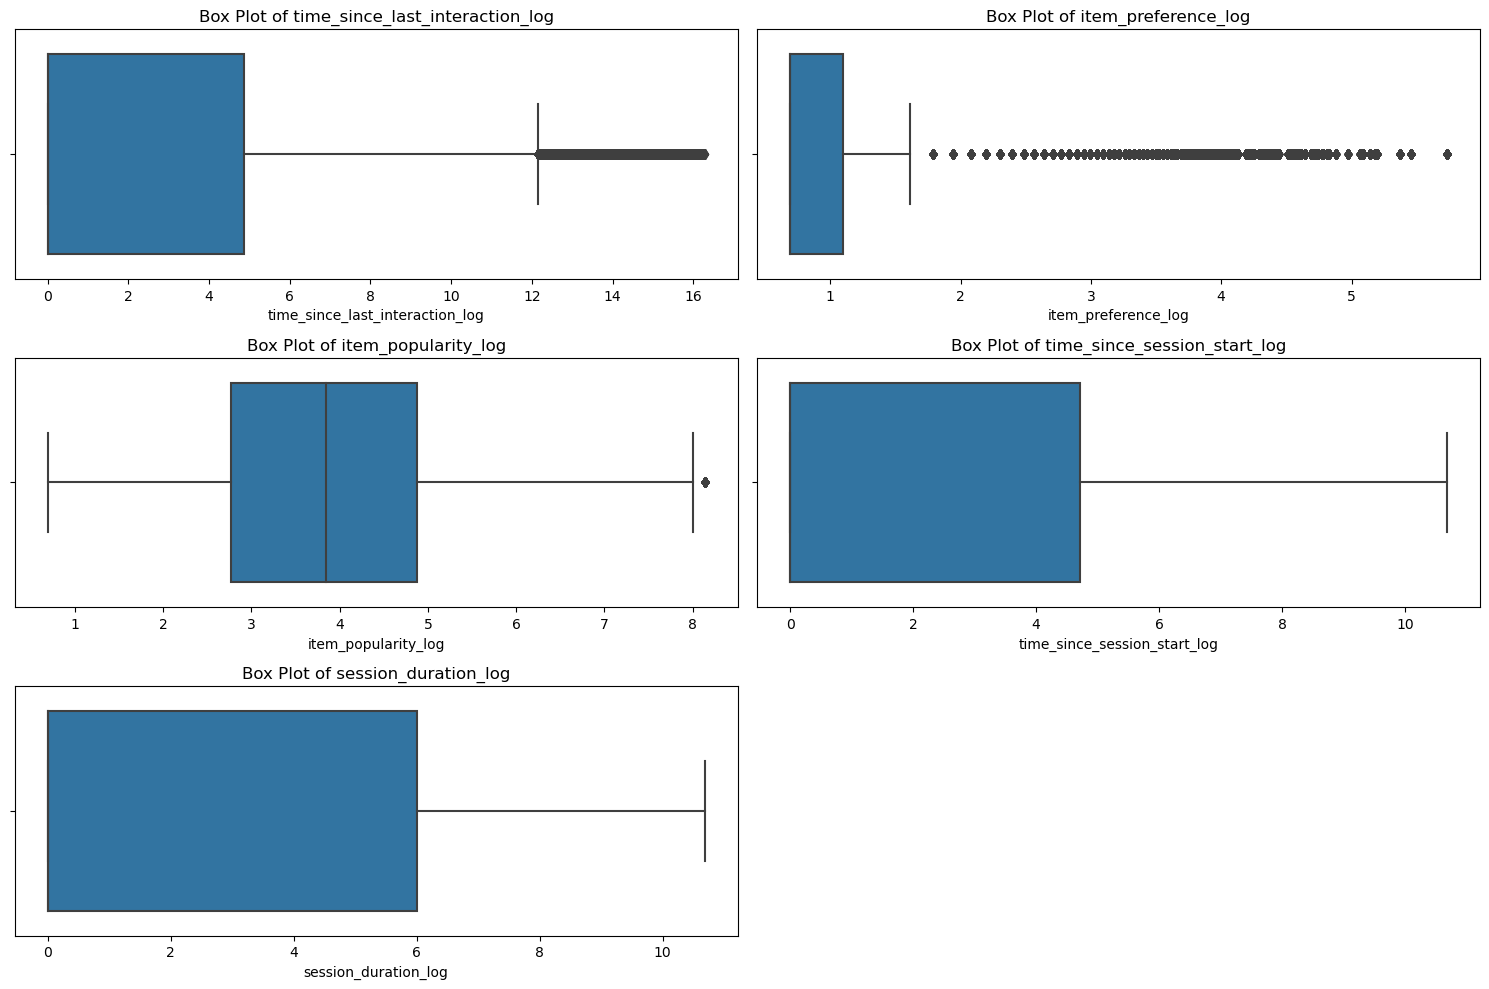

In [23]:
# List of features to plot
features = ['time_since_last_interaction_log', 'item_preference_log', 'item_popularity_log', 'time_since_session_start_log', 'session_duration_log']

# Create a figure and a set of subplots
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(3, 2, i)  # Adjust grid parameters based on the number of features
    sns.boxplot(x=data[feature].dropna())  # Drop NA values for cleaner plotting
    plt.title(f'Box Plot of {feature}')

plt.tight_layout()
plt.show()

In [24]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Initialize scalers
scaler_minmax = MinMaxScaler(feature_range=(0, 1))

# defining log transformed features
log_features = ['time_since_last_interaction_log', 'item_preference_log', 'item_popularity_log', 'time_since_session_start_log', 'session_duration_log']

# Fit and transform the features using StandardScaler
data_scaled_minmax = scaler_minmax.fit_transform(data[log_features])

# Convert scaled data back to DataFrame (optional, for better integration with pandas)
data_scaled_minmax_df = pd.DataFrame(data_scaled_minmax, columns=[f + 'scaled' for f in log_features])

#add these back to the original DataFrame
data = pd.concat([data, data_scaled_minmax_df], axis=1)

# Check the scaled data
print(data.head())


                      timestamp  visitorid event  itemid category  \
2655436 2015-09-11 20:49:49.439          0  view  285930     1188   
2655495 2015-09-11 20:52:39.591          0  view  357564      256   
2655555 2015-09-11 20:55:17.175          0  view   67045      333   
2126598 2015-08-13 17:46:06.444          1  view   72028     1192   
2024720 2015-08-07 17:51:44.567          2  view  325215      299   

                     time_diff  session_duration  \
2655436                    NaT           327.736   
2655495 0 days 00:02:50.152000           327.736   
2655555 0 days 00:02:37.584000           327.736   
2126598                    NaT             0.000   
2024720                    NaT          1753.278   

                         global_session_id  time_since_session_start  \
2655436  0:START:20150911204949:DUR:00327s                     0.000   
2655495  0:START:20150911204949:DUR:00327s                   170.152   
2655555  0:START:20150911204949:DUR:00327s              

In [25]:
data.head()

,timestamp,visitorid,event,itemid,category,time_diff,session_duration,global_session_id,time_since_session_start,interaction_type_id,...,time_since_last_interaction_log,item_preference_log,item_popularity_log,time_since_session_start_log,session_duration_log,time_since_last_interaction_logscaled,item_preference_logscaled,item_popularity_logscaled,time_since_session_start_logscaled,session_duration_logscaled
2655436,2015-09-11 20:49:49.439,0,view,285930,1188,NaT,327.736,0:START:20150911204949:DUR:00327s,0.000,3,...,0.000000,0.693147,4.564348,0.000000,5.795255,0.189860,0.080446,0.229065,0.289316,0.468937
2655495,2015-09-11 20:52:39.591,0,view,357564,256,0 days 00:02:50.152000,327.736,0:START:20150911204949:DUR:00327s,170.152,3,...,5.142552,0.693147,5.605802,5.142552,5.795255,0.000000,0.000000,0.883486,0.000000,0.000000
2655555,2015-09-11 20:55:17.175,0,view,67045,333,0 days 00:02:37.584000,327.736,0:START:20150911204949:DUR:00327s,327.736,3,...,5.066284,0.693147,5.327876,5.795255,5.795255,0.000000,0.000000,0.738648,0.000000,0.000000
2126598,2015-08-13 17:46:06.444,1,view,72028,1192,NaT,0.000,1:START:20150813174606:DUR:00000s,0.000,3,...,0.000000,0.693147,3.970292,0.000000,0.000000,0.000000,0.000000,0.339379,0.000000,0.000000
2024720,2015-08-07 17:51:44.567,2,view,325215,299,NaT,1753.278,2:START:20150807175144:DUR:01753s,0.000,3,...,0.000000,1.386294,4.744932,0.000000,7.469813,0.244409,0.298417,0.684853,0.657039,0.677851


In [26]:
data.drop(columns=['time_diff', 'time_since_last_interaction', 'item_preference', 'item_popularity', 'time_since_session_start', 'session_duration', 'time_since_last_interaction_log', 'item_preference_log', 'item_popularity_log', 'time_since_session_start_log', 'session_duration_log'], inplace=True)
data.head()

,timestamp,visitorid,event,itemid,category,global_session_id,interaction_type_id,time_since_last_interaction_logscaled,item_preference_logscaled,item_popularity_logscaled,time_since_session_start_logscaled,session_duration_logscaled
2655436,2015-09-11 20:49:49.439,0,view,285930,1188,0:START:20150911204949:DUR:00327s,3,0.189860,0.080446,0.229065,0.289316,0.468937
2655495,2015-09-11 20:52:39.591,0,view,357564,256,0:START:20150911204949:DUR:00327s,3,0.000000,0.000000,0.883486,0.000000,0.000000
2655555,2015-09-11 20:55:17.175,0,view,67045,333,0:START:20150911204949:DUR:00327s,3,0.000000,0.000000,0.738648,0.000000,0.000000
2126598,2015-08-13 17:46:06.444,1,view,72028,1192,1:START:20150813174606:DUR:00000s,3,0.000000,0.000000,0.339379,0.000000,0.000000
2024720,2015-08-07 17:51:44.567,2,view,325215,299,2:START:20150807175144:DUR:01753s,3,0.244409,0.298417,0.684853,0.657039,0.677851


In [27]:
# Calculate the number of events in each session
session_lengths_interaction = data.groupby('global_session_id').size()

c:\Users\nafla\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


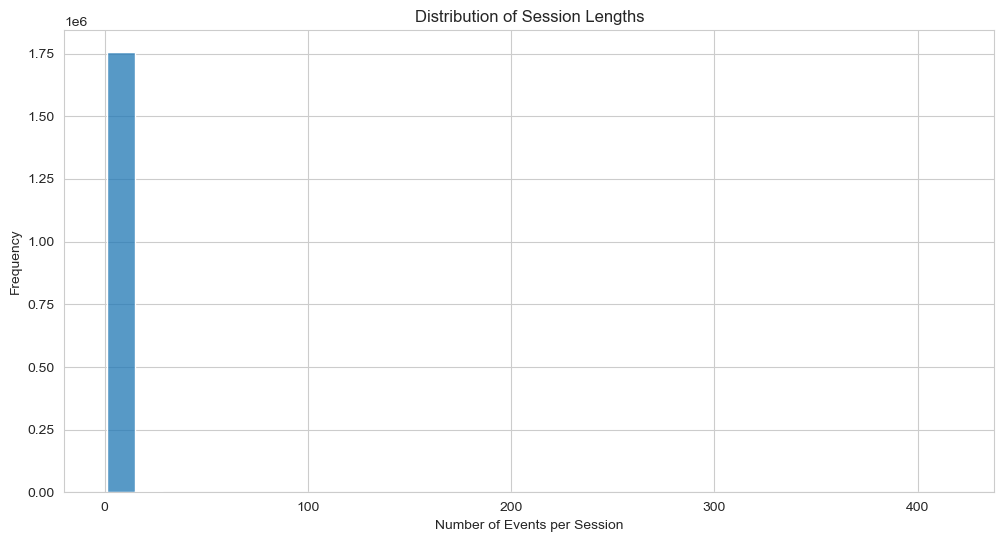

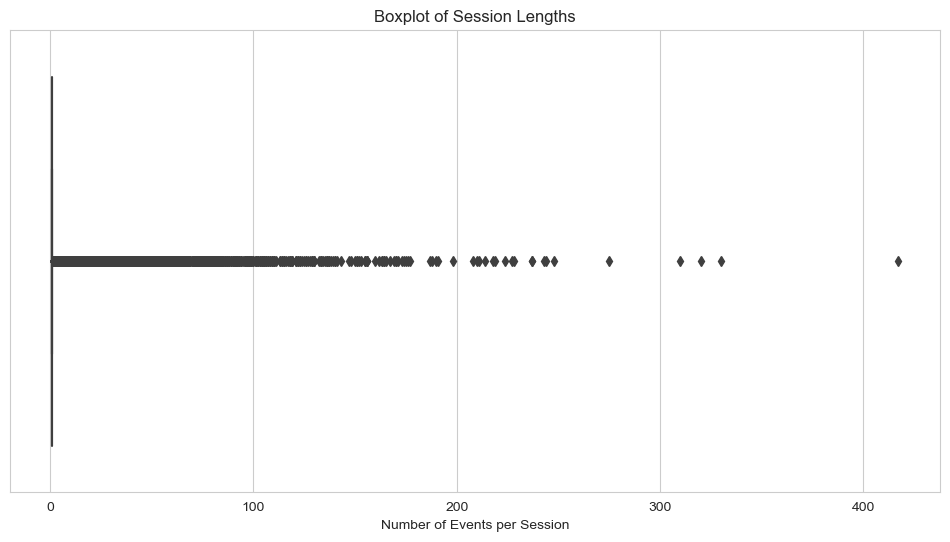

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot histogram of session lengths
plt.figure(figsize=(12, 6))
sns.histplot(session_lengths_interaction, bins=30, kde=False)
plt.title('Distribution of Session Lengths')
plt.xlabel('Number of Events per Session')
plt.ylabel('Frequency')
plt.show()

# Plot boxplot to see the distribution and identify potential outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=session_lengths_interaction)
plt.title('Boxplot of Session Lengths')
plt.xlabel('Number of Events per Session')
plt.show()


In [29]:
# Filter session_lengths to find those sessions where the number of events is greater than 100
sessions_over_100 = session_lengths_interaction[session_lengths_interaction > 100]
# Count the number of sessions with more than 200 events
number_of_sessions_over_100 = sessions_over_100.count()

print(f"Number of sessions with more than 100 events: {number_of_sessions_over_100}")


Number of sessions with more than 100 events: 144


In [30]:
# Filter to find sessions with more than 1 and less than 100 events
filtered_session_ids = session_lengths_interaction[(session_lengths_interaction > 2) & (session_lengths_interaction < 100)].index

In [31]:
# Filter the original data to keep only the sessions of interest
filtered_data = data[data['global_session_id'].isin(filtered_session_ids)]

# Optional: Verify the results
print(filtered_data.head())
print(f"Number of sessions retained: {filtered_data['global_session_id'].nunique()}")


                      timestamp  visitorid event  itemid category  \
2655436 2015-09-11 20:49:49.439          0  view  285930     1188   
2655495 2015-09-11 20:52:39.591          0  view  357564      256   
2655555 2015-09-11 20:55:17.175          0  view   67045      333   
2024720 2015-08-07 17:51:44.567          2  view  325215      299   
2024760 2015-08-07 17:53:33.790          2  view  325215      299   

                         global_session_id  interaction_type_id  \
2655436  0:START:20150911204949:DUR:00327s                    3   
2655495  0:START:20150911204949:DUR:00327s                    3   
2655555  0:START:20150911204949:DUR:00327s                    3   
2024720  2:START:20150807175144:DUR:01753s                    3   
2024760  2:START:20150807175144:DUR:01753s                    3   

         time_since_last_interaction_logscaled  item_preference_logscaled  \
2655436                               0.189860                   0.080446   
2655495                     

In [32]:
filtered_data.head()

,timestamp,visitorid,event,itemid,category,global_session_id,interaction_type_id,time_since_last_interaction_logscaled,item_preference_logscaled,item_popularity_logscaled,time_since_session_start_logscaled,session_duration_logscaled
2655436,2015-09-11 20:49:49.439,0,view,285930,1188,0:START:20150911204949:DUR:00327s,3,0.189860,0.080446,0.229065,0.289316,0.468937
2655495,2015-09-11 20:52:39.591,0,view,357564,256,0:START:20150911204949:DUR:00327s,3,0.000000,0.000000,0.883486,0.000000,0.000000
2655555,2015-09-11 20:55:17.175,0,view,67045,333,0:START:20150911204949:DUR:00327s,3,0.000000,0.000000,0.738648,0.000000,0.000000
2024720,2015-08-07 17:51:44.567,2,view,325215,299,2:START:20150807175144:DUR:01753s,3,0.244409,0.298417,0.684853,0.657039,0.677851
2024760,2015-08-07 17:53:33.790,2,view,325215,299,2:START:20150807175144:DUR:01753s,3,0.000000,0.000000,0.287558,0.000000,0.000000


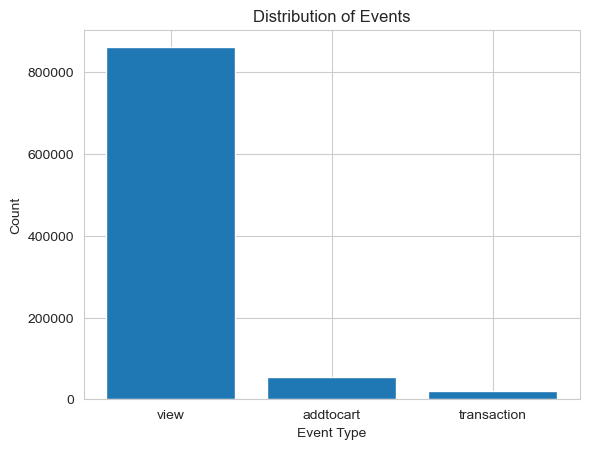

In [33]:
# Get the number of events
event_counts = filtered_data['event'].value_counts()

# Create a bar chart
plt.bar(event_counts.index, event_counts.values)
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.title('Distribution of Events')
plt.show()

In [34]:
# Check the number of sessions with less than 2 events
session_lengths = filtered_data.groupby('global_session_id').size()
num_sessions_less_than_2 = (session_lengths < 2 ).sum()
print("Number of sessions with less than 2 events:", num_sessions_less_than_2)

Number of sessions with less than 2 events: 0


In [35]:
# Save the filtered data to a new CSV file
filtered_data.to_csv('C:/Users/nafla/Downloads/article/dataset/filtered_sessions.csv', index=False)